In [116]:
import numpy as np
import pandas as pd
from scipy import spatial, stats, cluster
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import plotting, input_data
from nilearn.datasets import fetch_atlas_schaefer_2018
import networkx as nx
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import bct
import glob

%matplotlib inline

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


Lo levanté de acá https://github.com/danjgale/psyc-917/blob/9ac6414cdb878a18f2db6e9e9a2a8752e64b0c0a/11_Network_Analysis.ipynb
Lindo repo de un chango que enseña Cognitive Neuroimaging en Oh, Canada. 

Y acá también conseguí el repo de un ruso rockero re capo Vitaliy Pozdnyakov que enseña grafos
https://github.com/vpozdnyakov/network_science_assignments/network/members
y sus alumnos hicieron funciones en base a sus assignments con las mismas redes que aprendimos en CyT

In [117]:
dfLabels = pd.read_csv("../resources/aal_extended.csv",header=None) 
dfLabels.columns = ['reindex','name','mark','region','side']
dfLabels["region_side"] = dfLabels["region"] + "_" + dfLabels["side"]

print(dfLabels.head())

labels = dfLabels['name'].values

   reindex               name  mark   region side region_side
0        1       Precentral_L  2001  Central    L   Central_L
1        2       Precentral_R  2002  Central    R   Central_R
2        3      Frontal_Sup_L  2101  Frontal    L   Frontal_L
3        4      Frontal_Sup_R  2102  Frontal    R   Frontal_R
4        5  Frontal_Sup_Orb_L  2111  Frontal    L   Frontal_L


In [118]:
array_labels = dfLabels.region_side.unique()
array_labels

array(['Central_L', 'Central_R', 'Frontal_L', 'Frontal_R', 'Insula_L',
       'Insula_R', 'Limbic_L', 'Limbic_R', 'Subcortical_L',
       'Subcortical_R', 'Occipital_L', 'Occipital_R', 'Parietal_L',
       'Parietal_R', 'Temporal_L', 'Temporal_R', 'Cerebelum_L',
       'Cerebelum_R', 'Cerebelum_--'], dtype=object)

In [119]:
array_labels = ['Central_L', 'Central_R', 'Frontal_L', 'Frontal_R', 'Insula_L',
       'Insula_R', 'Cerebelum_L',
       'Cerebelum_R', 'Cerebelum_--','Limbic_L', 'Limbic_R', 'Subcortical_L',
       'Subcortical_R', 'Occipital_L', 'Occipital_R', 'Parietal_L',
       'Parietal_R', 'Temporal_L', 'Temporal_R', ]

In [120]:
NUM_COLORS=len(set(dfLabels['region_side']))
cm = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_map = {lab:scalarMap.to_rgba(i) for lab,i in zip(array_labels,range(len(array_labels)))}
#color_map

In [121]:
#color_map = {'Frontal': '#0173b2', 'Temporal': '#de8f05', 'Parietal': '#029e73', 'Central': '#d55e00', 'Limbic': '#cc78bc', 'Occipital': '#ca9161', 'Insula': '#fbafe4', 'Subcortical': '#949494', 'Cerebelum': '#ece133'}
def set_color(x):
    return color_map[x]
node_colors = [set_color(x) for x in dfLabels['region_side'].values]
node_network = dfLabels['region_side'].values
#node_colors

In [122]:
def plot_grafo_kamada_kawai_layout(G,tipo_red,edgewidth=1.0,node_size_param1=.1,node_size_param2=.7):
    f = plt.figure()
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

    weight_widths = [(.06 + edgewidth*x) ** 10 for x in weights]
    node_size = [(node_size_param1+node_size_param2*j)**1.55 for i, j in nx.degree(G,weight='weight')]

    layout = nx.kamada_kawai_layout(G,weight='weight')
    nx.draw_networkx_nodes(G, layout, weight='weight',
                         node_size = node_size,
                         node_color=node_colors,
                         edge_color = "skyblue", # 엣지 색상
                         # edge_color=colors,
                         edgecolors=node_colors,
                         alpha = 0.7, # 노드와 엣지의 투명도
                         with_labels = True, # 노드 이름 표시 여부
                         font_size=10, # 폰트 사이즈
                         font_family='Malgun Gothic', # 한글설정
                         arrowsize = 10) # 화살표 크기
    nx.draw_networkx_labels(G, layout, font_color='k', font_size=6, weight='weight',)
    nx.draw_networkx_edges(G, layout, edgelist=edges, width=weight_widths, edge_color = "skyblue", weight='weight',)

    plt.rc('font', family='Malgun Gothic') # 폰트 문제
    #plt.title(f'network_{tipo_red}') # 그래프 제목
    plt.axis('off');
    
    ax = f.add_subplot(1,1,1)

    for label in color_map:
        ax.plot([0],[0],color=color_map[label],label=label)
    plt.axis('off')
    f.set_facecolor('w')

    plt.legend(prop={'size': 8},title=f'network_{tipo_red}',title_fontsize=10)

    f.tight_layout()

    plt.savefig(f'../graficos/network_{tipo_red}.png') # 파일 저장

In [123]:
def plot_grafo_promedio(tipo_red):
    path = r'../resources/DataSujetos' # use your path
    all_files = glob.glob(path + f"/{tipo_red}_suj*.csv")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, header=None, index_col=None,)
        li.append(df)
        print(filename)

    frame = pd.concat(li, axis=0)
    by_row_index = frame.groupby(frame.index)
    df_means = by_row_index.mean()
    
    plt.figure()
    thresh_cmat = bct.threshold_absolute(df_means.values, thr=.4)
    plotting.plot_matrix(thresh_cmat, vmax=1, vmin=-1);

    label_data = pd.DataFrame({'number': np.arange(len(labels)) + 1, 'region_side': labels})

    G = nx.from_numpy_matrix(thresh_cmat)
    G = nx.relabel_nodes(G, lambda x: label_data['number'].tolist()[x])
    
    plot_grafo_kamada_kawai_layout(G,tipo_red)

../resources/DataSujetos\N1_suj1.csv
../resources/DataSujetos\N1_suj10.csv
../resources/DataSujetos\N1_suj11.csv
../resources/DataSujetos\N1_suj12.csv
../resources/DataSujetos\N1_suj13.csv
../resources/DataSujetos\N1_suj14.csv
../resources/DataSujetos\N1_suj15.csv
../resources/DataSujetos\N1_suj16.csv
../resources/DataSujetos\N1_suj17.csv
../resources/DataSujetos\N1_suj18.csv
../resources/DataSujetos\N1_suj2.csv
../resources/DataSujetos\N1_suj3.csv
../resources/DataSujetos\N1_suj4.csv
../resources/DataSujetos\N1_suj5.csv
../resources/DataSujetos\N1_suj6.csv
../resources/DataSujetos\N1_suj7.csv
../resources/DataSujetos\N1_suj8.csv
../resources/DataSujetos\N1_suj9.csv


C:\Users\Faolin\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


../resources/DataSujetos\N2_suj1.csv
../resources/DataSujetos\N2_suj10.csv
../resources/DataSujetos\N2_suj11.csv
../resources/DataSujetos\N2_suj12.csv
../resources/DataSujetos\N2_suj13.csv
../resources/DataSujetos\N2_suj14.csv
../resources/DataSujetos\N2_suj15.csv
../resources/DataSujetos\N2_suj16.csv
../resources/DataSujetos\N2_suj17.csv
../resources/DataSujetos\N2_suj18.csv
../resources/DataSujetos\N2_suj2.csv
../resources/DataSujetos\N2_suj3.csv
../resources/DataSujetos\N2_suj4.csv
../resources/DataSujetos\N2_suj5.csv
../resources/DataSujetos\N2_suj6.csv
../resources/DataSujetos\N2_suj7.csv
../resources/DataSujetos\N2_suj8.csv
../resources/DataSujetos\N2_suj9.csv


C:\Users\Faolin\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


../resources/DataSujetos\N3_suj1.csv
../resources/DataSujetos\N3_suj10.csv
../resources/DataSujetos\N3_suj11.csv
../resources/DataSujetos\N3_suj12.csv
../resources/DataSujetos\N3_suj13.csv
../resources/DataSujetos\N3_suj14.csv
../resources/DataSujetos\N3_suj15.csv
../resources/DataSujetos\N3_suj16.csv
../resources/DataSujetos\N3_suj17.csv
../resources/DataSujetos\N3_suj18.csv
../resources/DataSujetos\N3_suj2.csv
../resources/DataSujetos\N3_suj3.csv
../resources/DataSujetos\N3_suj4.csv
../resources/DataSujetos\N3_suj5.csv
../resources/DataSujetos\N3_suj6.csv
../resources/DataSujetos\N3_suj7.csv
../resources/DataSujetos\N3_suj8.csv
../resources/DataSujetos\N3_suj9.csv


C:\Users\Faolin\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


../resources/DataSujetos\W_suj1.csv
../resources/DataSujetos\W_suj10.csv
../resources/DataSujetos\W_suj11.csv
../resources/DataSujetos\W_suj12.csv
../resources/DataSujetos\W_suj13.csv
../resources/DataSujetos\W_suj14.csv
../resources/DataSujetos\W_suj15.csv
../resources/DataSujetos\W_suj16.csv
../resources/DataSujetos\W_suj17.csv
../resources/DataSujetos\W_suj18.csv
../resources/DataSujetos\W_suj2.csv
../resources/DataSujetos\W_suj3.csv
../resources/DataSujetos\W_suj4.csv
../resources/DataSujetos\W_suj5.csv
../resources/DataSujetos\W_suj6.csv
../resources/DataSujetos\W_suj7.csv
../resources/DataSujetos\W_suj8.csv
../resources/DataSujetos\W_suj9.csv


C:\Users\Faolin\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 1200x600 with 0 Axes>

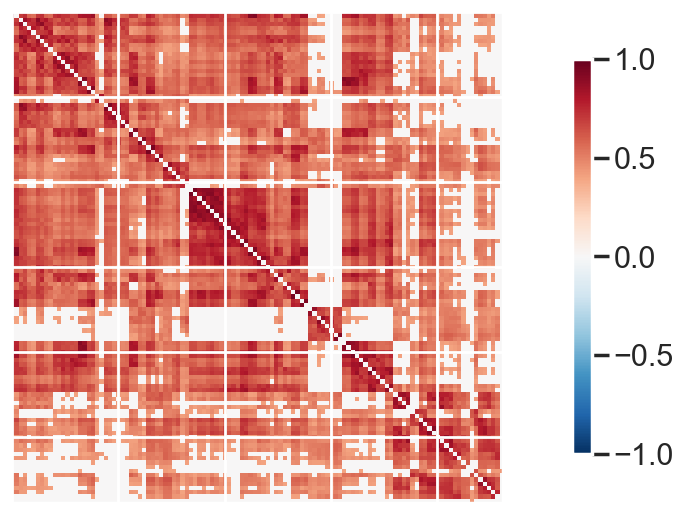

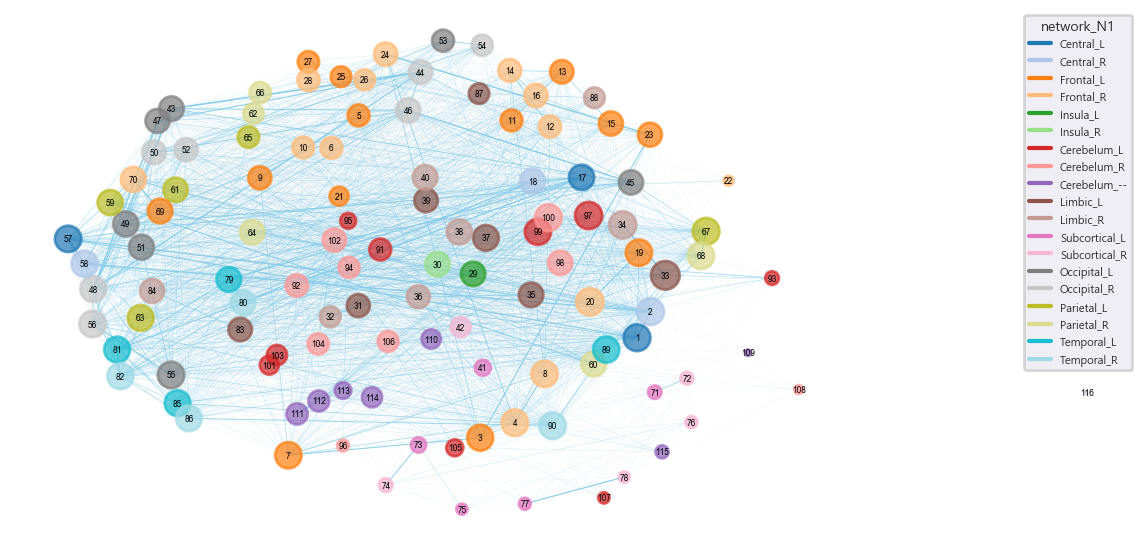

<Figure size 1200x600 with 0 Axes>

C:\Users\Faolin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Faolin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


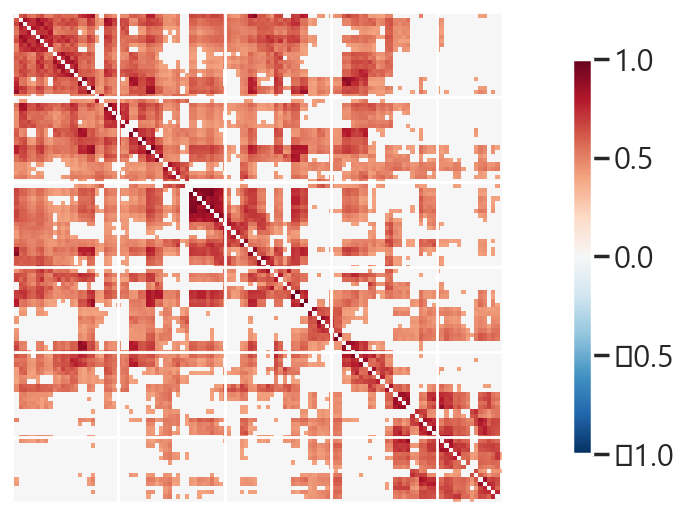

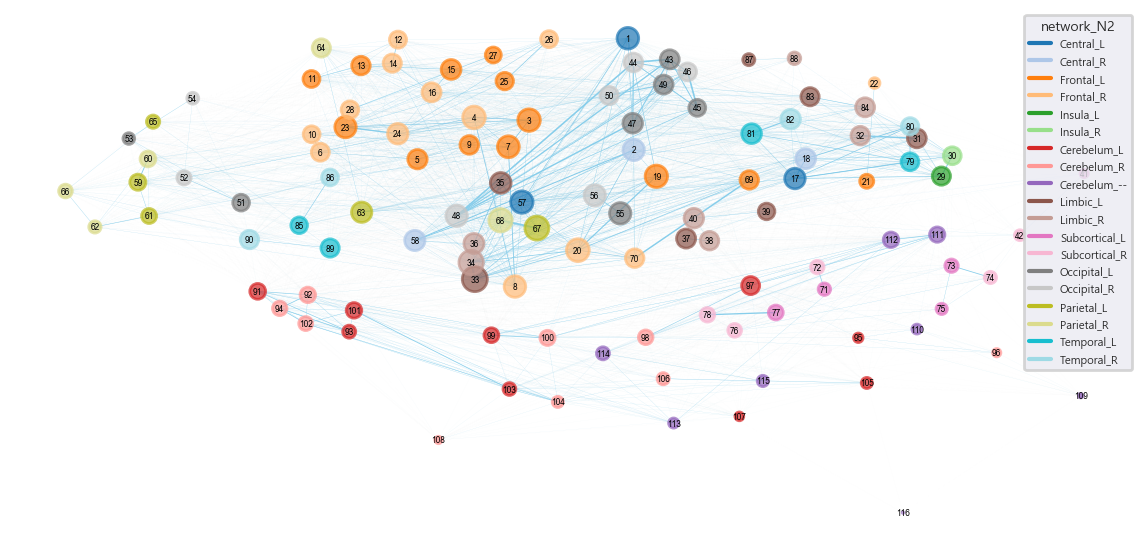

<Figure size 1200x600 with 0 Axes>

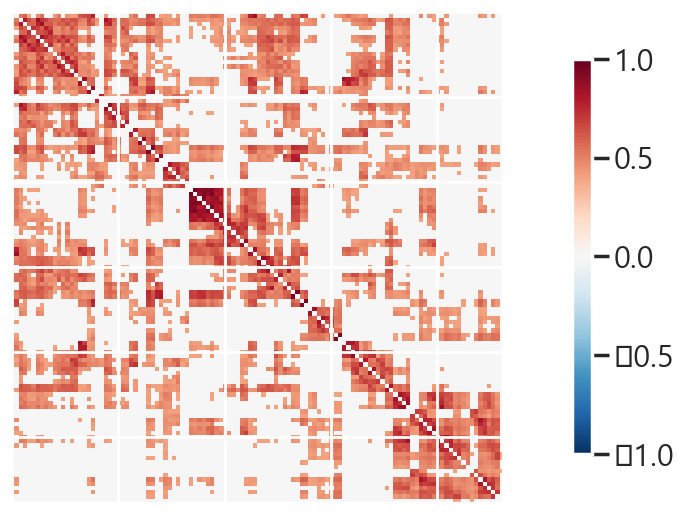

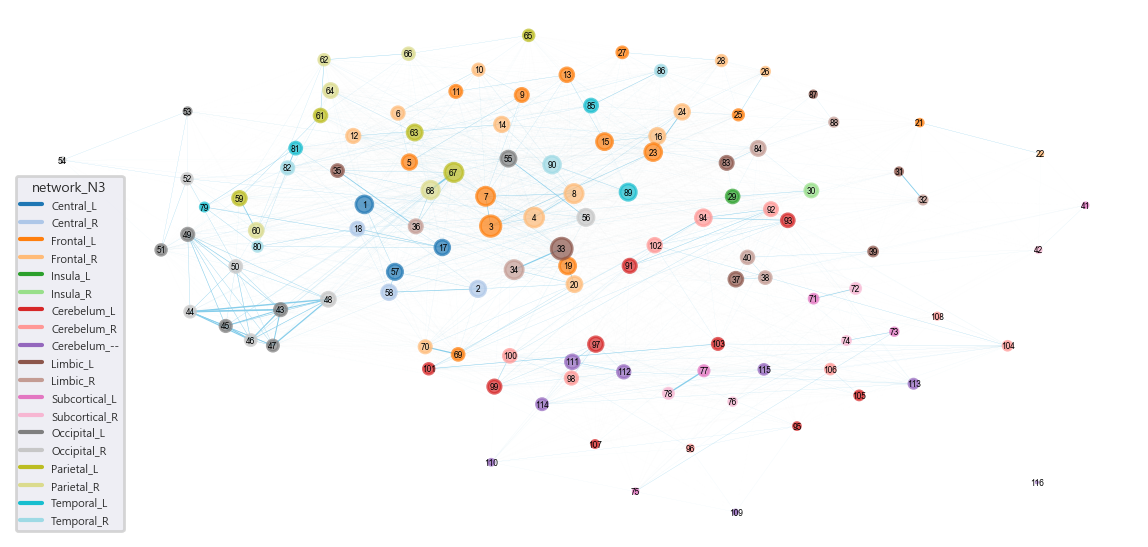

<Figure size 1200x600 with 0 Axes>

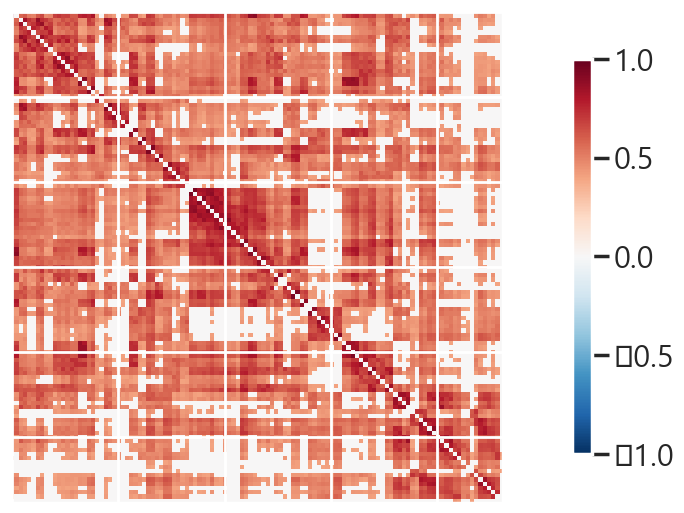

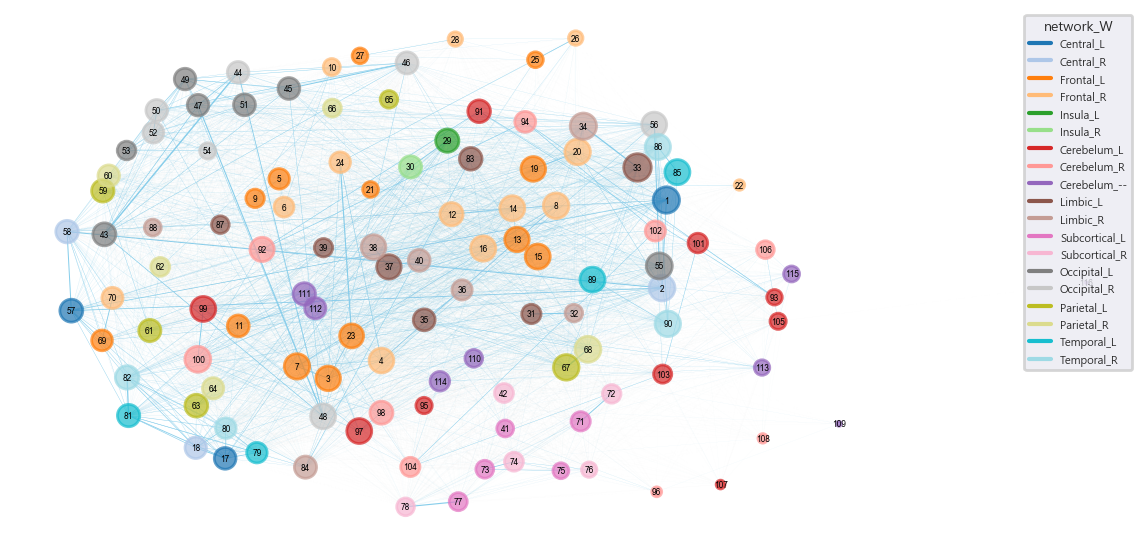

In [124]:
plot_grafo_promedio("N1")
plot_grafo_promedio("N2")
plot_grafo_promedio("N3")
plot_grafo_promedio("W")

In [125]:
def get_grafo_from_df(df,edges_density):
    n = df.shape[0]
    df -= np.diag(np.ones(n))

    sort_corrs = sorted(df.values.flatten(),reverse=True)
    threshold = sort_corrs[edges_density]
    thresh_cmat = (df.values >= threshold) * 1.0
    G = nx.from_numpy_matrix(thresh_cmat)

    label_data = pd.DataFrame({'number': np.arange(len(labels)) + 1, 'region_side': labels})
    G = nx.relabel_nodes(G, lambda x: label_data['number'].tolist()[x])
    return(G,thresh_cmat)

In [126]:
def plot_grafo_promedio_umbral(tipo_red):
    path = r'../resources/DataSujetos' # use your path
    all_files = glob.glob(path + f"/{tipo_red}_suj*.csv")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, header=None, index_col=None,)
        li.append(df)
        print(filename)

    frame = pd.concat(li, axis=0)
    by_row_index = frame.groupby(frame.index)
    df_means = by_row_index.mean()
    
    G, thresh_cmat = get_grafo_from_df(df_means,900)
    
    plt.figure()
    plotting.plot_matrix(thresh_cmat, vmax=1, vmin=-1);
    
    plot_grafo_kamada_kawai_layout(G,tipo_red+"_umbral",0.8,10.0,1.2)

In [ ]:
plot_grafo_promedio_umbral("N1")
plot_grafo_promedio_umbral("N2")
plot_grafo_promedio_umbral("N3")
plot_grafo_promedio_umbral("W")

../resources/DataSujetos\N1_suj1.csv
../resources/DataSujetos\N1_suj10.csv
../resources/DataSujetos\N1_suj11.csv
../resources/DataSujetos\N1_suj12.csv
../resources/DataSujetos\N1_suj13.csv
../resources/DataSujetos\N1_suj14.csv
../resources/DataSujetos\N1_suj15.csv
../resources/DataSujetos\N1_suj16.csv
../resources/DataSujetos\N1_suj17.csv
../resources/DataSujetos\N1_suj18.csv
../resources/DataSujetos\N1_suj2.csv
../resources/DataSujetos\N1_suj3.csv
../resources/DataSujetos\N1_suj4.csv
../resources/DataSujetos\N1_suj5.csv
../resources/DataSujetos\N1_suj6.csv
../resources/DataSujetos\N1_suj7.csv
../resources/DataSujetos\N1_suj8.csv
../resources/DataSujetos\N1_suj9.csv


C:\Users\Faolin\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


../resources/DataSujetos\N2_suj1.csv
../resources/DataSujetos\N2_suj10.csv
../resources/DataSujetos\N2_suj11.csv
../resources/DataSujetos\N2_suj12.csv
../resources/DataSujetos\N2_suj13.csv
../resources/DataSujetos\N2_suj14.csv
../resources/DataSujetos\N2_suj15.csv
../resources/DataSujetos\N2_suj16.csv
../resources/DataSujetos\N2_suj17.csv
../resources/DataSujetos\N2_suj18.csv
../resources/DataSujetos\N2_suj2.csv
../resources/DataSujetos\N2_suj3.csv
../resources/DataSujetos\N2_suj4.csv
../resources/DataSujetos\N2_suj5.csv
../resources/DataSujetos\N2_suj6.csv
../resources/DataSujetos\N2_suj7.csv
../resources/DataSujetos\N2_suj8.csv
../resources/DataSujetos\N2_suj9.csv


C:\Users\Faolin\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
